In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
import cftime
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

/var/folders/7y/lr_w90f56s35gmw3l6ghkz_w0000gn/T/ipykernel_42721/2597540415.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [ ]:
# df_tas_ncar_piC = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'esm-piControl'")

# zstore_piC = df_tas_ncar_piC.zstore.values[-1]
# print(zstore_piC)
# mapper_piC = fsspec.get_mapper(zstore_piC)
# ds_tas_piC = xr.open_zarr(mapper_piC, consolidated=True)


# date_threshold = cftime.DatetimeNoLeap(000, 1, 1)
# ds_tas_piC_plt = ds_tas_piC.copy()
# # weighted product
# tas_timeseries_piC = (ds_tas_piC_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# # convert to np array
# array_tas_ts = np.array(tas_timeseries_piC)
# print(array_tas_ts.mean())

"""
The output is:
287.19836
I will directly use hard copy
"""

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [3]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='historical'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [4]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
# df_tas_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR'")

# df_ta_ncar.experiment_id.unique()
# df_tas_ncar

In [5]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_tas_his = xr.open_zarr(mapper_his, consolidated=True)
display(ds_tas_his)

date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time > date_threshold, drop=True)
# weighted product
tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# convert to np array
array_tas_ts = np.array(tas_timeseries_his)
# plt.plot(array_tas_ts)
# plt.show()
year_tas_ts = np.mean(array_tas_ts.reshape(1980//12, 12), axis=1)
# plt.plot(year_tas_ts)
# plt.show()

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/tas/gn/v20190514/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/a7278f6d-6a1b-4050-8f06-a8033604736a...
    version_id:             v20190514

In [6]:
df_radflux_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'rtmt' & institution_id == 'NCAR' & experiment_id == 'historical'")

zstore_his = df_radflux_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_radflux_his = xr.open_zarr(mapper_his, consolidated=True)

# time threshold for security
date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
ds_radflux_his_plt = ds_radflux_his.where(ds_radflux_his.time > date_threshold, drop=True)
display(ds_radflux_his_plt)

radflux_timeseries_his = (ds_radflux_his_plt.rtmt * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
array_radflux_ts = np.array(radflux_timeseries_his)
# plt.plot(array_radflux_ts)
# plt.show()
year_radflux_ts = np.mean(array_radflux_ts.reshape(len(array_radflux_ts) // 12, 12), axis=1)
# plt.plot(year_radflux_ts)
# plt.show()


gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/Amon/rtmt/gn/v20190514/


<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    rtmt       (time, lat, lon) float32 dask.array<chunksize=(318, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    tracking_id:            hdl:21.14100/b23da9b0-37c7-4698-8a8f-b5d223e59796...
    variable_id:            rtmt
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/b23da9b0-37c7-4698-8a8f-b5d223e59796...
    version_id:             v20190514

$N = F - \alpha \Delta T$

### By selecting different reference temperature, F takes different value, but climate feedback parameter a remains the same

Climate Feedback Parameter (a): 4.586 W/m²/K
Radiative Forcing (F): 0.907 W/m²


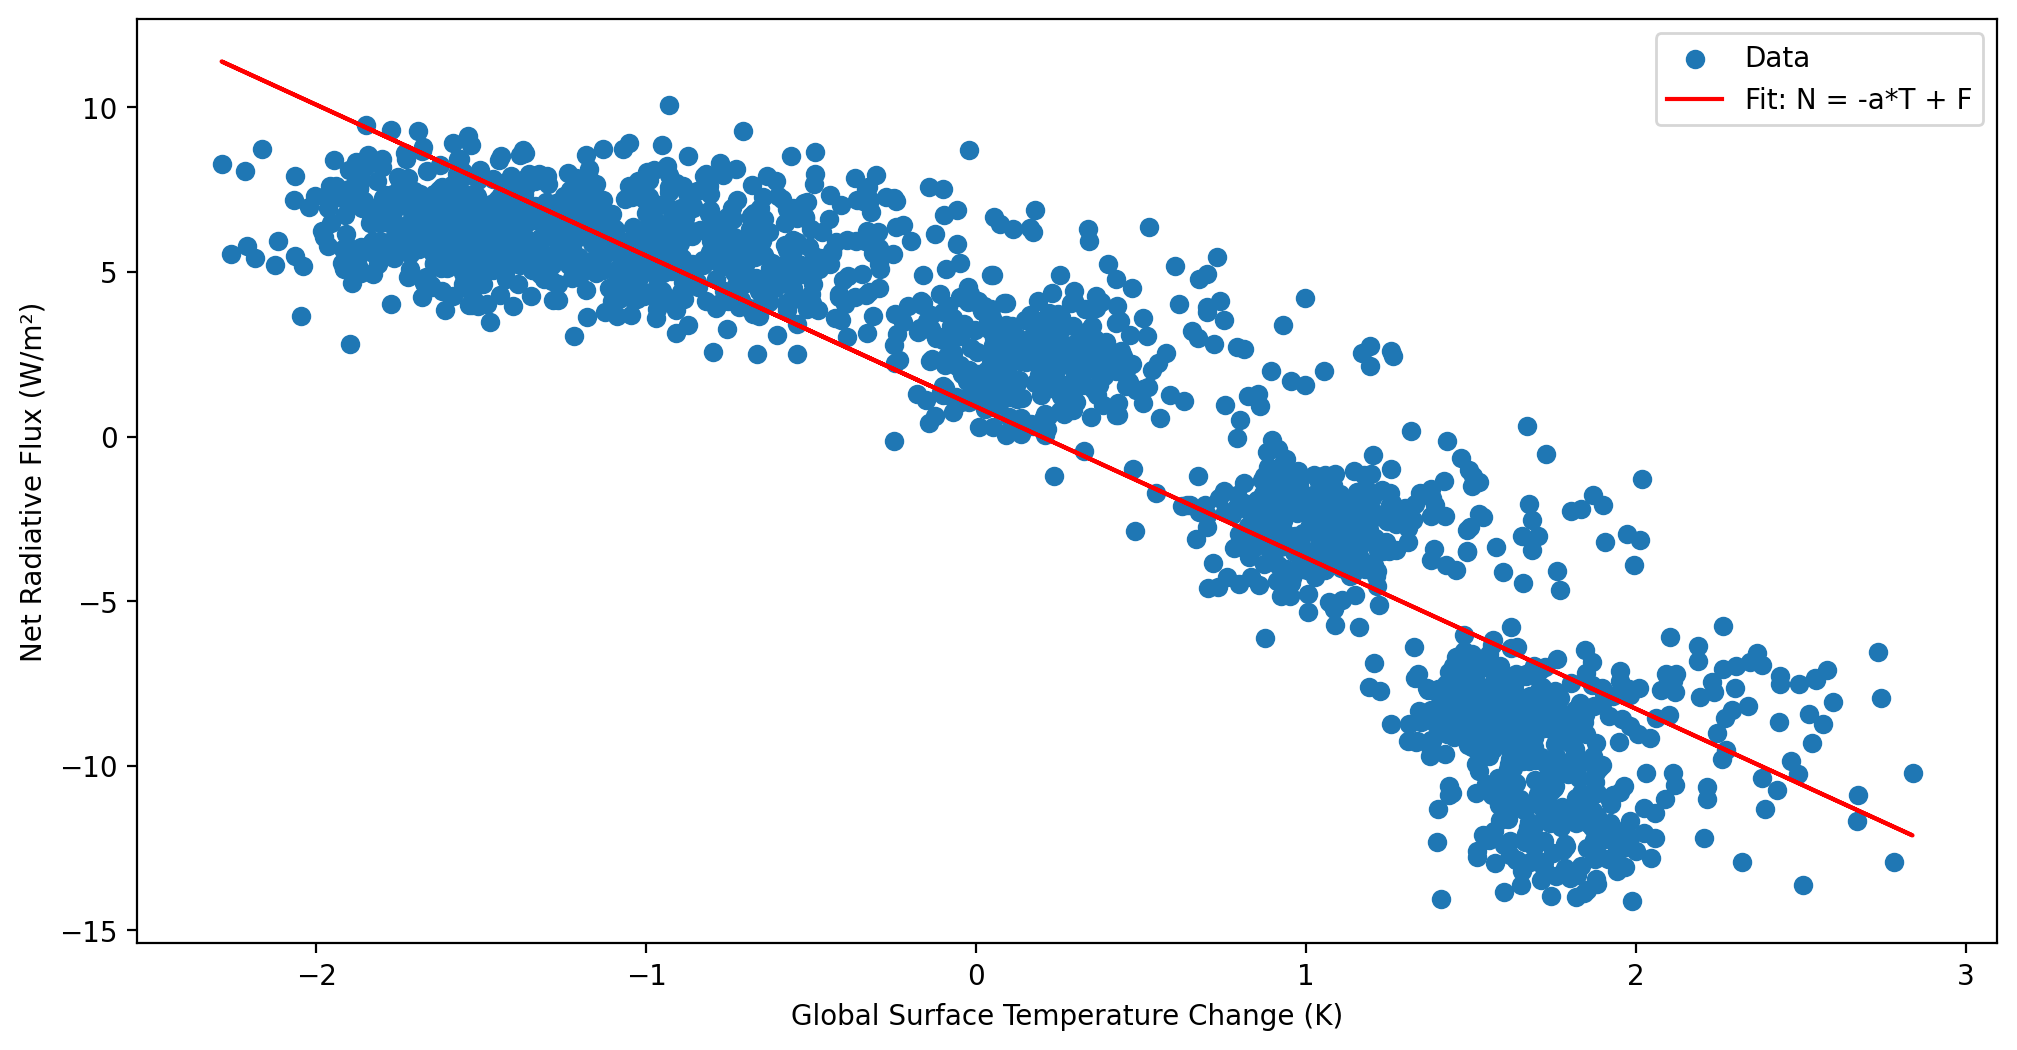

In [7]:

delta_T= array_tas_ts - 287.19836
N = array_radflux_ts

X = delta_T.reshape(-1, 1)
y = N

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Extract results
a = -model.coef_[0]  # Slope is negative feedback parameter
F = model.intercept_  # Intercept is radiative forcing

print(f"Climate Feedback Parameter (a): {a:.3f} W/m²/K")
print(f"Radiative Forcing (F): {F:.3f} W/m²")

# Optional: Plot
plt.scatter(delta_T, N, label="Data")
plt.plot(delta_T, model.predict(X), color='red', label="Fit: N = -a*T + F")
plt.xlabel("Global Surface Temperature Change (K)")
plt.ylabel("Net Radiative Flux (W/m²)")
plt.legend()
plt.show()

In [8]:
df_co2_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'co2' & institution_id == 'NCAR'")
df_co2_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'co2' & institution_id == 'NCAR' & experiment_id == 'historical'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_co2_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_co2_his = xr.open_zarr(mapper_his, consolidated=True)
date_threshold = cftime.DatetimeNoLeap(1550, 1, 1)
ds_co2_his_plt = ds_co2_his.where(ds_co2_his.time > date_threshold, drop=True)
display(ds_co2_his_plt)

ds_co2_his_plt_500 = ds_co2_his_plt.sel(plev=50000).drop_vars("plev")
co2_timeseries_his = (ds_co2_his_plt_500.co2 * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
array_co2_ts = np.array(co2_timeseries_his)
month_co2_ts = array_co2_ts.copy()

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4i1p1f1/Amon/co2/gn/v20191105/


<xarray.Dataset>
Dimensions:    (time: 1980, plev: 19, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    co2        (time, plev, lat, lon) float32 dask.array<chunksize=(68, 19, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  182500.0
    case_id:                18
    ...                     ...
    tracking_id:            hdl:21.14100/0ff3a523-63b9-455f-9d61-dd3f71732764
    variable_id:            co2
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r4i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/0ff3a523-63b9-455f-9d61-dd3f71732764
    version_id:             v20191105

Radiative Forcing Efficiency (epsilon): 9.749 W/m²
Climate Feedback Parameter (alpha): 4.732 W/m²/K
Baseline Radiative Flux (Intercept): -0.458 W/m²


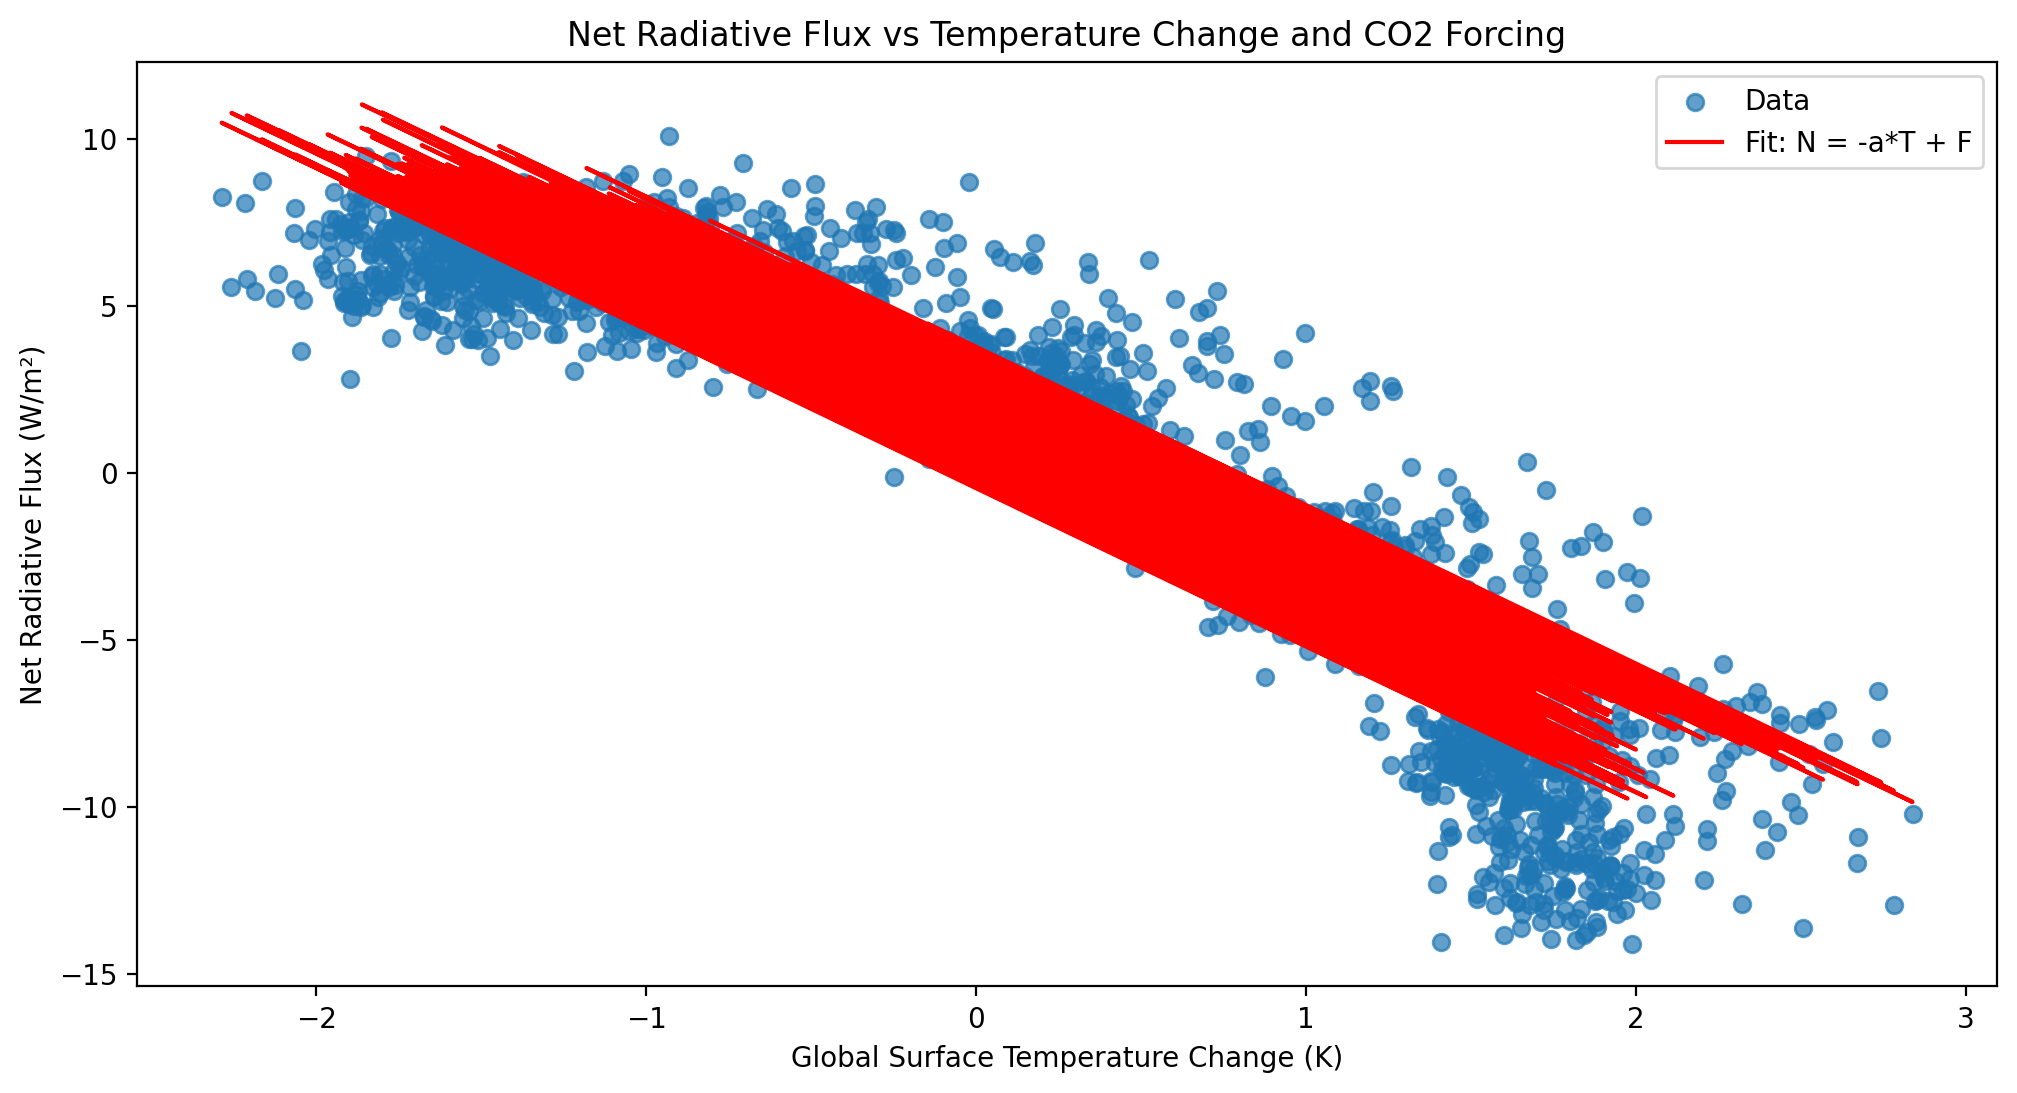

In [9]:
# Sample data (replace with your time series)
CO2 = month_co2_ts * 1000000         # Atmospheric CO2 concentrations (ppm)
delta_T= array_tas_ts - 287.19836
N = array_radflux_ts         # Net downward radiative flux (W/m²)

# Calculate the logarithmic forcing term
log_forcing = np.log(CO2 / 280)  # Reference CO2 concentration = 280 ppm

# Prepare independent variables for multiple linear regression
X = np.column_stack((log_forcing, delta_T))  # Combine \ln(CO2/280) and \Delta T

# Perform multiple linear regression
model = LinearRegression()
model.fit(X, N)

# Extract coefficients
epsilon = model.coef_[0]  # Coefficient for \ln(CO2 / 280)
alpha = -model.coef_[1]   # Negative of the slope for \Delta T (feedback parameter)
F_intercept = model.intercept_  # Intercept (baseline radiative flux if both terms are zero)

# Print results
print(f"Radiative Forcing Efficiency (epsilon): {epsilon:.3f} W/m²")
print(f"Climate Feedback Parameter (alpha): {alpha:.3f} W/m²/K")
print(f"Baseline Radiative Flux (Intercept): {F_intercept:.3f} W/m²")

# Optional: Plot results
plt.scatter(delta_T, N, label="Data", alpha=0.7)
plt.plot(delta_T, model.predict(X), color='red', label="Fit: N = -a*T + F")
plt.xlabel("Global Surface Temperature Change (K)")
plt.ylabel("Net Radiative Flux (W/m²)")
plt.title("Net Radiative Flux vs Temperature Change and CO2 Forcing")
plt.legend()
plt.show()

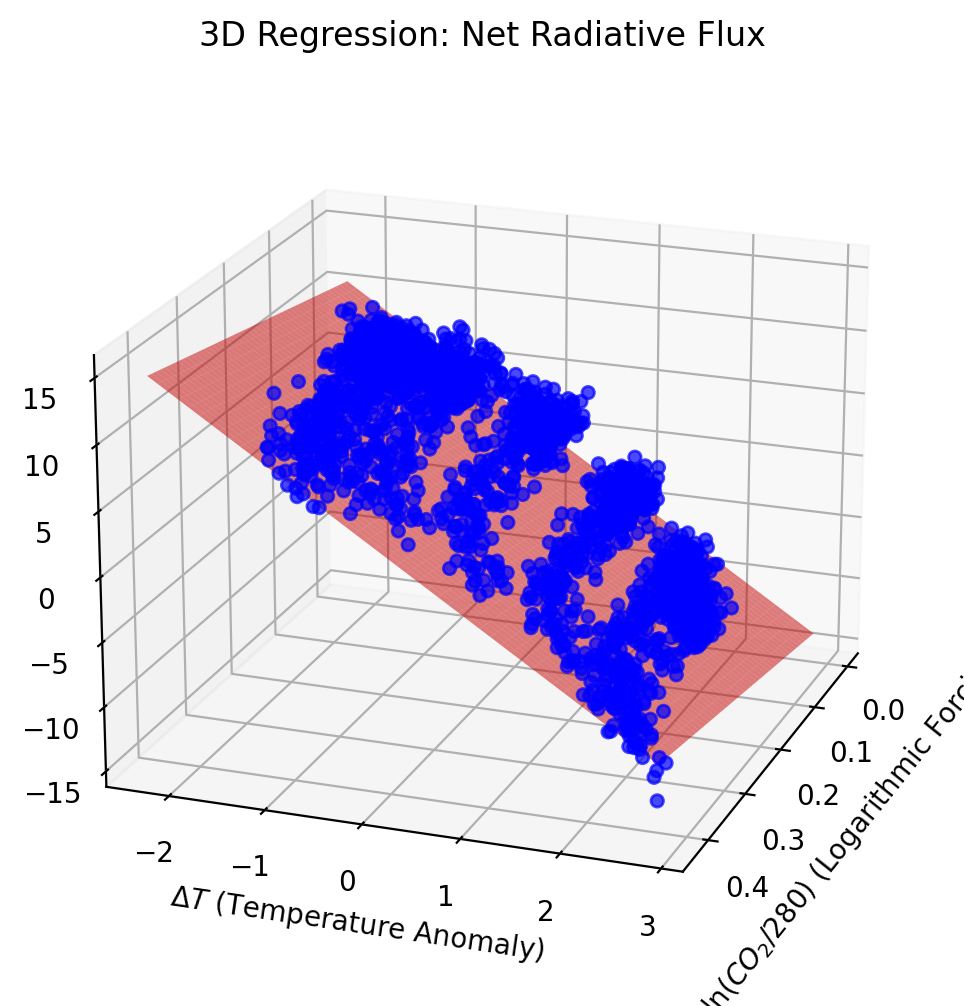

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(log_forcing, delta_T, N, label="Data Points", color='blue', alpha=0.7)

# Generate a regression surface
log_forcing_range = np.linspace(min(log_forcing), max(log_forcing), 50)
delta_T_range = np.linspace(min(delta_T), max(delta_T), 50)
log_forcing_grid, delta_T_grid = np.meshgrid(log_forcing_range, delta_T_range)
N_predicted = (
    model.intercept_
    + model.coef_[0] * log_forcing_grid
    + model.coef_[1] * delta_T_grid
)

# Plot the regression surface
ax.plot_surface(
    log_forcing_grid, delta_T_grid, N_predicted, color='red', alpha=0.5, label="Regression Surface"
)

# Label the axes
ax.set_xlabel(r"$\ln(CO_2 / 280)$ (Logarithmic Forcing)")
ax.set_ylabel(r"$\Delta T$ (Temperature Anomaly)")
ax.set_zlabel(r"$N$ (Net Radiative Flux)")
ax.set_title("3D Regression: Net Radiative Flux")

ax.view_init(elev=20, azim=20)
# Show the plot
plt.show()